# Synthetic Images from simulated data


## Authors

Yi-Hao Chen & Sebastian Heinz


## Learning Goals

- Assign WCS astrometry to an image using ```astropy.wcs``` 
- Construct a PSF using ```astropy.modeling.model```
- Convolve raw data with PSF using ```astropy.convolution```
- Calculate polarization fraction and angle from Stokes I, Q, U data
- Overplot quivers on the image


## Keywords

astrometry, WCS, fits image, fits Header, polarization, radio, stokes parameters, PSF, convolution, quiver plot, visualization


## Steps

[1. Load and examine the FITS file](#1.-Load-and-examine-the-FITS-file)

[2. Set up astrometry coordinates](#2.-Set-up-astrometry-coordinates)

[3. Prepare a Point Spread Function (PSF)](#3.-Prepare-a-Point-Spread-Function-(PSF))

>[3.a How to do this without astropy kernels](#3.a-How-to-do-this-without-astropy-kernels)

[4. Convolve image with PSF](#4.-Convolve-image-with-PSF)

[5. Exercise: add some noise to the data](#5.-Exercise:-add-some-noise-to-the-data)

[6. Convolve Stokes Q and U images](#6.-Convolve-Stokes-Q-and-U-images)

[7. Calculate polarization angle and fraction for quiver plot](7.-Calculate-polarization-angle-and-fraction-for-quiver-plot)

In [1]:
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

## 1. Load and examine the FITS file

Here we begin with a 2-dimensional data that were stored in FITS format from some simulations. We have Stokes I, Q, and U maps. We will first load a FITS file and examine the header.

<div class="alert alert-info">
Note that this tutorial requires downloading data. Please download the FITS file: [file1](http://www.astro.wisc.edu/~ychen/MHD_Jet/fits_dtau_005c/synchrotron_i_lobe_0700_150MHz.fits)
</div>

In [2]:
hdulist = fits.open('./synchrotron_i_lobe_0700_150MHz.fits')
hdulist.info()

hdu = hdulist['NN_EMISSIVITY_I_LOBE_150.0MHZ']
hdu.header

Filename: ./synchrotron_i_lobe_0700_150MHz.fits
No.    Name         Type      Cards   Dimensions   Format
  0  NN_EMISSIVITY_I_LOBE_150.0MHZ  PrimaryHDU      22   (2048, 4096)   float64   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =               1024.5                                                  
CRPIX2  =               2048.5                                                  
CDELT1  = 9.42382812499999E+

We can see this FITS file, which was created in yt, has x and y coordinate in physical units (cm). We want to convert it into sky coordinates. Before we proceed, let's find out the range of the data and plot a histogram. 

129.717785809
0.0


/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


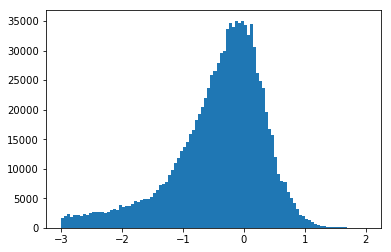

In [3]:
print(hdu.data.max())
print(hdu.data.min())
plt.hist(np.log10(hdu.data.flatten()), range=(-3, 2), bins=100 )
plt.show()

Once we know the range of the data, we can do a visualization with the proper range (```vmin``` and ```vmax```).

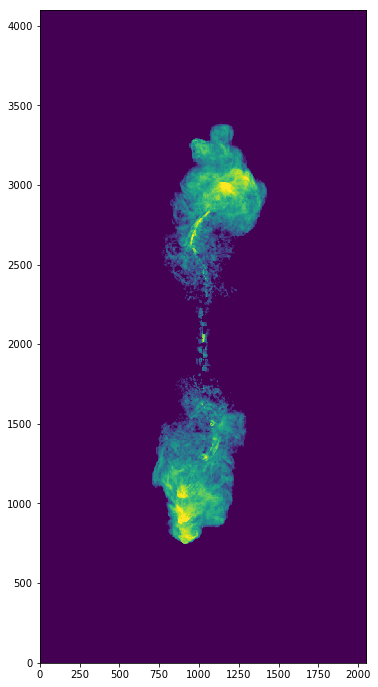

In [4]:
fig = plt.figure(figsize=(6,12))
fig.add_subplot(111)

# We plot it in log-scale and add a small number to avoid nan values. 
plt.imshow(np.log10(hdu.data+1E-3), vmin=-1, vmax=1, origin='lower')
plt.show()

## 2. Set up astrometry coordinates

From the header, we know that the x and y axes are in centimeter. However, in an observation we usually have RA and DEC. To convert physical units to sky coordinates, we will need to make some assumptions about where the object is located, i.e. the distance to the object and the central RA and DEC. 

In [5]:
# distance to the object
dist_obj = 200*u.Mpc

# We have the RA in hh:mm:ss and DEC in dd:mm:ss format. 
# We will use Skycoord to convert them into degrees later.
ra_obj = '19h59m28.3566s'
dec_obj = '+40d44m02.096s'

Here we convert the pixel scale from cm to degree by dividing the distance to the object.

In [6]:
cdelt1 = ((hdu.header['CDELT1']*u.cm/dist_obj.to('cm'))*u.rad).to('deg')
cdelt2 = ((hdu.header['CDELT2']*u.cm/dist_obj.to('cm'))*u.rad).to('deg')
print(cdelt1, cdelt2)

8.749222239908287e-06 deg 8.749222239908287e-06 deg


Use ```astropy.wcs.WCS``` to prepare a FITS header.

In [7]:
w = WCS(naxis=2)

# reference pixel coordinate
w.wcs.crpix = [hdu.data.shape[0]/2,hdu.data.shape[1]/2]

# sizes of the pixel in degrees
w.wcs.cdelt = [-cdelt1.base, cdelt2.base]

# converting ra and dec into degrees
c = SkyCoord(ra_obj, dec_obj)
w.wcs.crval = [c.ra.deg, c.dec.deg]

# the units of the axes are in degrees
w.wcs.cunit = ['deg', 'deg']

Convert the wcs coordinate into header and update the hdu.

In [8]:
wcs_header = w.to_header()
hdu.header.update(wcs_header)

Take a look of the header. ```CDELT1```, ```CDELT2```, ```CUNIT1```, ```CUNIT2```, ```CRVAL1```, and ```CRVAL2``` are in sky coordinates now.

In [9]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =               2048.0                                                  
CRPIX2  =               1024.0                                                  
CDELT1  = -8.7492222399083E-

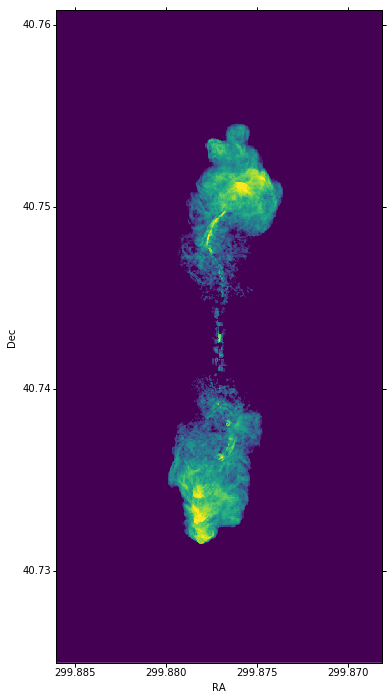

In [10]:
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(6,12))
fig.add_subplot(111, projection=wcs)
plt.imshow(np.log10(hdu.data+1e-3), vmin=-1, vmax=1, origin='lower')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Now we have the sky coordinate for the image!

## 3. Prepare a Point Spread Function (PSF)

Simple PSFs are included in ```astropy.convolution.kernel```. We will use ```astropy.convolution.Gaussian2DKernel``` here.
First we need to set the telescope resolution. For a 2D Gaussian, we can calculate sigma in pixels by using our pixel scale keyword ```cdelt2``` from above.

In [11]:
# assume our telescope has 1 arcsecond resolution
telescope_resolution=1*u.arcsecond

# calculate the sigma in pixels. 
# since cdelt is in degrees, we use _.to('deg')
sigma=telescope_resolution.to('deg')/cdelt2

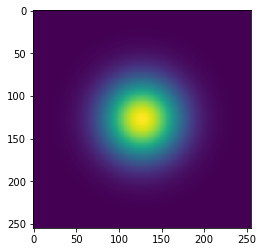

In [12]:
from astropy.convolution import Gaussian2DKernel
# By default, the Gaussian kernel will go to 4 sigma
# in each direction
psf = Gaussian2DKernel(sigma)

# let's take a look:
plt.imshow(psf)
plt.show()

## 3.a How to do this without astropy kernels

Maybe your PSF is more complicated. Here's an alternative way to do this, using a 2D Lorentzian

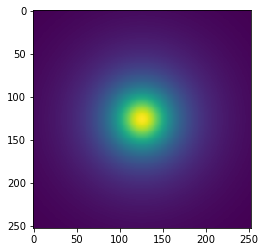

In [13]:
# suppose we wanted a 2D Lorentzian, that could be done like this:
from astropy.modeling.models import Lorentz1D

# set FWHM and psf grid
telescope_resolution = 1*u.arcsecond
gamma = telescope_resolution.to('deg')/cdelt2
x_grid = np.outer(np.linspace(-gamma*4,gamma*4,int(8*gamma)),np.ones(int(8*gamma)))
r_grid = np.sqrt(x_grid**2 + np.transpose(x_grid**2))
lorentzian = Lorentz1D(fwhm=2*gamma)

# extrude a 2D azimuthally symmetric PSF
lorentzian_psf = lorentzian(r_grid)

# normalization
lorentzian_psf /= np.sum(lorentzian_psf)

# let's take a look again:
plt.imshow(lorentzian_psf, interpolation='none')
plt.show()

## 4. Convolve image with PSF

Here we use ```astropy.convolution.convolve_fft``` to convolve image. This routine uses fourier transform for faster calculation. Especially our data is $2^n$ sized, which makes it particually fast. Using a fft, however, causes boundary effects. We will need to specify how we want to handle the boundary. Here we choose to "wrap" the data, which means making the data periodic. 

In [14]:
from astropy.convolution import convolve_fft

convolved_image = convolve_fft(hdu.data, psf, boundary='wrap')

In [15]:
# Put a psf at the corner of the image
delta_x_psf=100 # number of pixels from the edges
xmin, xmax = -psf.shape[1]-delta_x_psf, -delta_x_psf
ymin, ymax = delta_x_psf, delta_x_psf+psf.shape[0]
convolved_image[xmin:xmax, ymin:ymax] = psf.array/psf.array.max()*10

Now let's take a look of the convolved image.

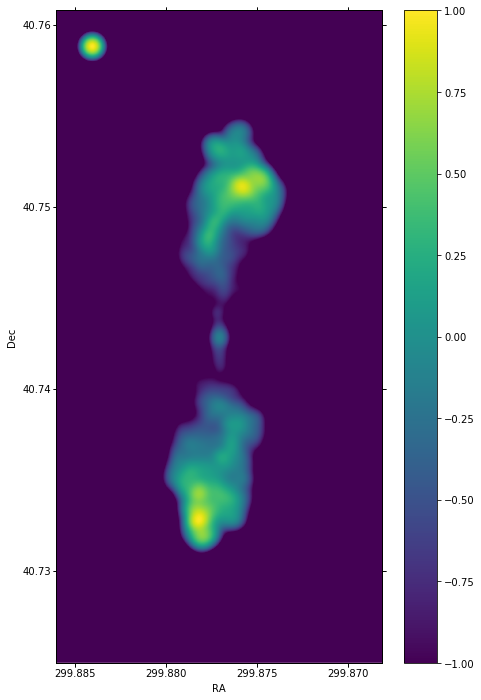

In [16]:
wcs = WCS(hdu.header)
fig = plt.figure(figsize=(8,12))
i_plot = fig.add_subplot(111, projection=wcs)
plt.imshow(np.log10(convolved_image+1e-3), vmin=-1, vmax=1.0, origin='lower')#, cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()
plt.show()

## 5. Exercise: add some noise to the data

## 6. Convolve Stokes Q and U images

<div class="alert alert-info">
Please download the FITS files: [file2](http://www.astro.wisc.edu/~ychen/MHD_Jet/fits_dtau_005c/synchrotron_q_lobe_0700_150MHz.fits), [file3](http://www.astro.wisc.edu/~ychen/MHD_Jet/fits_dtau_005c/synchrotron_u_lobe_0700_150MHz.fits)
</div>

In [17]:
hdulist = fits.open('./synchrotron_q_lobe_0700_150MHz.fits')
hdu_q = hdulist['NN_EMISSIVITY_Q_LOBE_150.0MHZ']
hdulist = fits.open('./synchrotron_u_lobe_0700_150MHz.fits')
hdu_u = hdulist['NN_EMISSIVITY_U_LOBE_150.0MHZ']

# Update the header with the wcs_header we created earlier
hdu_q.header.update(wcs_header)
hdu_u.header.update(wcs_header)

# Convolve the images with the the psf
convolved_image_q = convolve_fft(hdu_q.data, psf, boundary='wrap')
convolved_image_u = convolve_fft(hdu_u.data, psf, boundary='wrap')

Let's plot the Q and U images.

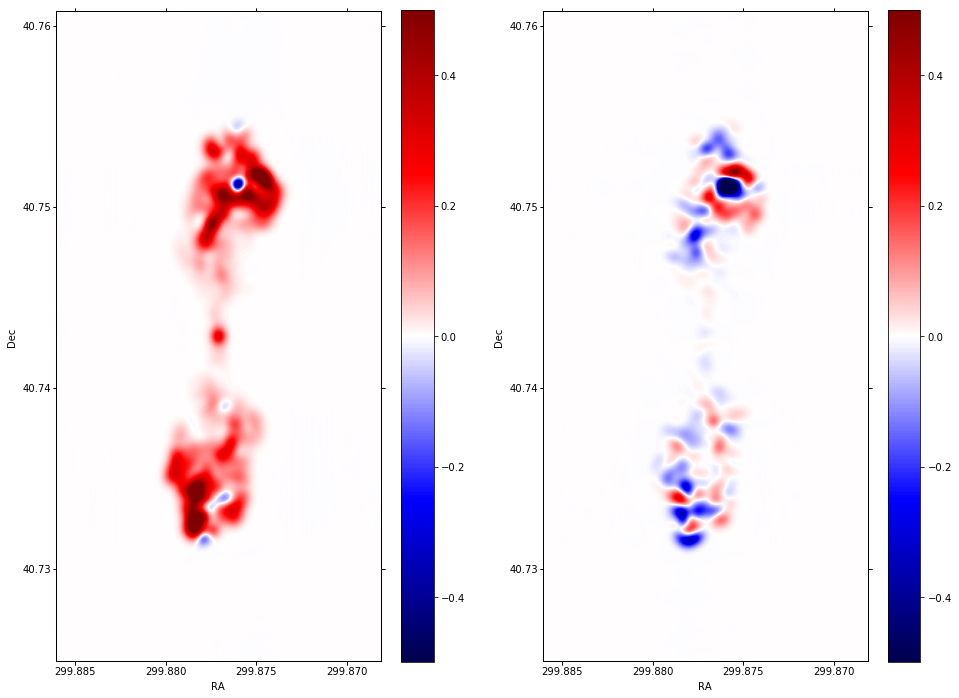

In [18]:
wcs = WCS(hdu.header)
fig = plt.figure(figsize=(16,12))
fig.add_subplot(121, projection=wcs)
plt.imshow(convolved_image_q, cmap='seismic', vmin=-0.5, vmax=0.5, origin='lower')#, cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

fig.add_subplot(122, projection=wcs)
plt.imshow(convolved_image_u, cmap='seismic', vmin=-0.5, vmax=0.5, origin='lower')#, cmap=plt.cm.viridis)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()
plt.show()

## 7. Calculate polarization angle and fraction for quiver plot 

Note that rotating Stokes Q and I maps requires changing signs of both. Here we assume that the Stokes q and u maps were calculated defining the y/declination axis as vertical, such that Q is positive for polarization vectors along the x/right-ascention axis.

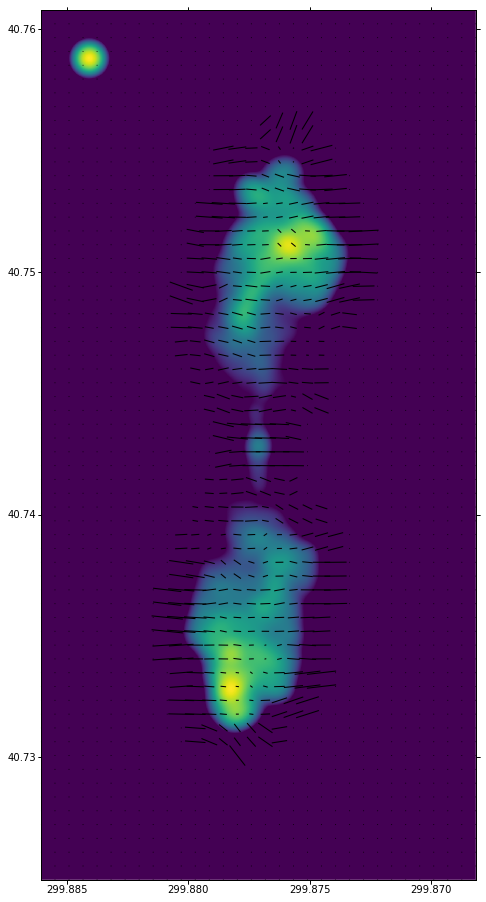

In [19]:
# First, we plot the background image
fig = plt.figure(figsize=(8,16))
i_plot = fig.add_subplot(111, projection=wcs)
i_plot.imshow(np.log10(convolved_image+1e-3), vmin=-1, vmax=1, origin='lower')

# ranges of the axis
xx0, xx1 = i_plot.get_xlim()
yy0, yy1 = i_plot.get_ylim()

# binning factor
factor = [64, 64]

# re-binned number of points in each axis
nx_new = convolved_image.shape[1] // factor[0]
ny_new = convolved_image.shape[0] // factor[1]

# These are the positions of the quivers
X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                  np.linspace(yy0,yy1,ny_new,endpoint=True))

# bin the data
I_bin = convolved_image.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
Q_bin = convolved_image_q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
U_bin = convolved_image_u.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

# polarization angle
psi = 0.5*np.arctan2(U_bin, Q_bin)

# polarization fraction
frac = np.sqrt(Q_bin**2+U_bin**2)/I_bin

# mask for low signal area
mask = I_bin < 0.1

frac[mask] = 0
psi[mask] = 0

pixX = frac*np.cos(psi) # X-vector 
pixY = frac*np.sin(psi) # Y-vector

# keyword arguments for quiverplots
quiveropts = dict(headlength=0, headwidth=1, pivot='middle')
i_plot.quiver(X, Y, pixX, pixY, scale=8, **quiveropts)
plt.show()

## Exercise: convert the units of the data from Jy/arcsec^2 to Jy/beam

The intensity of the data is given in unit of Jy/arcsec^2. Observational data usually have the intensity unit in Jy/beam. Assuming a beam size or take the psf we created earlier, you can convert the data into Jy/beam.